In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import os

### Importing data/basic viz

In [44]:
DATA_FOLDER = "AirQualityUCI"
DATA_FILE = "AirQualityUCI.csv"
#path = os.path.join('',DATA_FOLDER, DATA_FILE)
# load csv into df
df = pd.read_csv(r'/home/enishiwaki/dowgan-en/data/DataImpurityGAN.csv', 
                 sep=",")
#                 parse_dates=[['Date', 'Time']],
#                 decimal=',')

In [82]:
#Shape of data
print(f'shape of data: {df.shape}')

#Dropping date column and putting column names in a list bc they are so long
data = df.drop(df.columns[0],axis=1)
time = np.arange(0,len(data))
data.insert(0,'Time',time)

#List of all the column names
list_colnames=list(data)

shape of data: (10177, 47)


In [85]:
#Counting the number of null values in each column
na_vals = []
for x in np.arange(0,len(list_colnames)):
    na_vals.append(data[list_colnames[x]].isnull().sum())

na_vals_dict = dict(zip(np.arange(0,len(list_colnames)),na_vals))
print(na_vals_dict)

{0: 0, 1: 1, 2: 2, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 2, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 1, 24: 1, 25: 0, 26: 0, 27: 1, 28: 0, 29: 1, 30: 0, 31: 0, 32: 0, 33: 0, 34: 1, 35: 0, 36: 0, 37: 0, 38: 1, 39: 0, 40: 1, 41: 94, 42: 287, 43: 0, 44: 1, 45: 1, 46: 0}


In [73]:
def plot_dataframe(dataframe: pd.DataFrame,
                    x: str,
                    y: str,
                    title: str):
    """plots first 100 values from selected x and y columns of AirQuality dataframe"""
    plt.plot(dataframe[x][:500], dataframe[y][:500], label=y)
    #plt.xticks(dataframe[x][:500][0::10],
    #            rotation=45,
    #            ha='right')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)

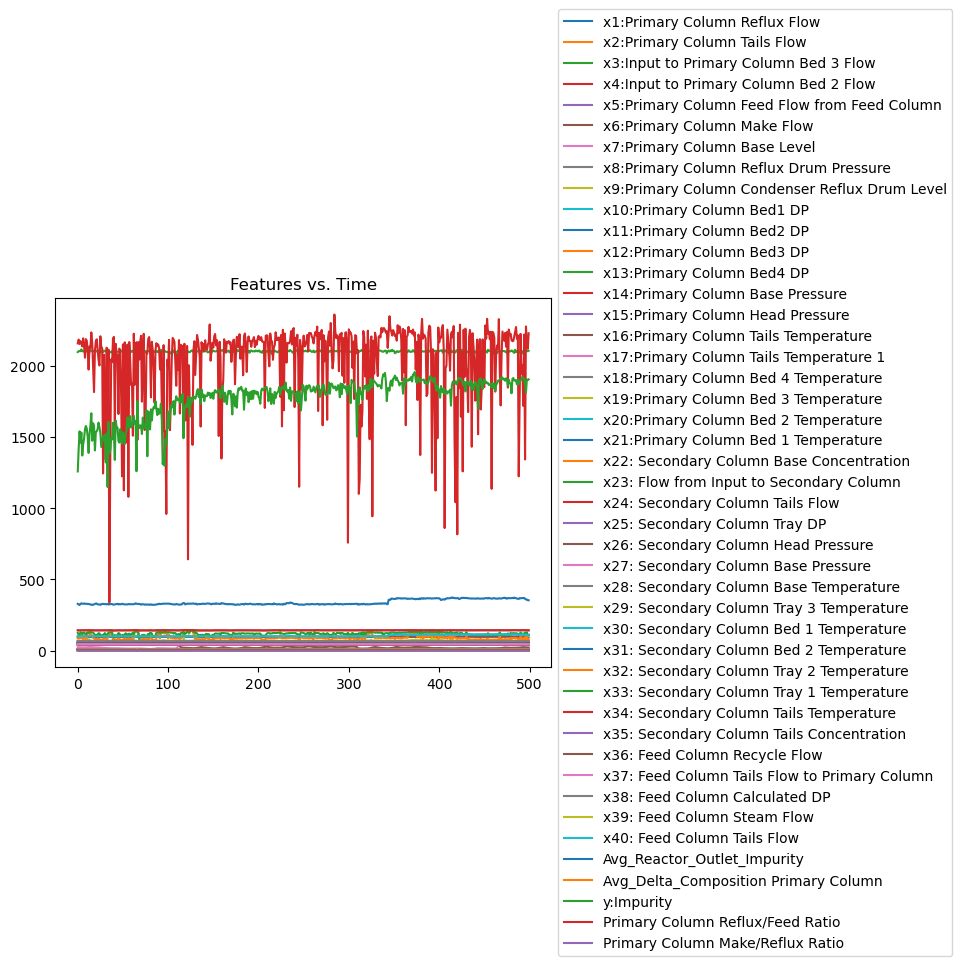

In [78]:
for i, column in enumerate(data.columns[1:]):
    if column == 'Class':
        break
    plot_dataframe(dataframe=data,
                   x='Time',
                   y=column,
                   title="Features vs. Time")

### Putting data into tensors and splitting into target and conditions

In [157]:
#Putting data into target and conditions tensors
#We flattened the target tensor with .reshape(-1,1) - not sure if we want that here yet.
target_tensor = torch.tensor(data.iloc[:,1:46].values, dtype=torch.float32)
print(f"shape of target_tensor (all features): {target_tensor.shape}")

conditions_tensor = torch.tensor(data['Class'].values, dtype=torch.float32).unsqueeze(dim=1)
print(f"shape of conditions_tensor (operating conditions): {conditions_tensor.shape}")

print(f'first timepoint (row): {target_tensor[0]}')
print(f'first feature (col): {target_tensor[:,0]}')

shape of target_tensor (all features): torch.Size([10177, 45])
shape of conditions_tensor (operating conditions): torch.Size([10177, 1])
first timepoint (row): tensor([3.2781e+02, 4.5792e+01, 2.0951e+03, 2.1560e+03, 9.8501e+01, 9.5467e+01,
        5.4348e+01, 4.1012e+01, 5.2235e+01, 6.8667e+00, 1.0678e+01, 8.1289e+00,
        8.5602e+00, 4.2239e+01, 4.0960e+01, 5.2695e+01, 2.3420e+01, 4.9476e+01,
        4.9594e+01, 5.0812e+01, 5.1384e+01, 1.4411e-02, 1.2572e+03, 8.7585e+00,
        6.3562e+00, 4.2654e+01, 4.3737e+01, 1.4268e+02, 6.6371e+01, 5.9468e+01,
        5.5846e+01, 8.4717e+01, 1.2433e+02, 1.4196e+02, 1.3060e-02, 6.2871e+01,
        4.5008e+01, 6.6660e+01, 8.6881e+00, 9.9961e+01, 5.3802e+00, 1.4971e+00,
        1.7783e+00, 3.3280e+00, 2.9123e-01])
first feature (col): tensor([327.8130, 322.9700, 319.6740,  ..., 396.0950, 392.2330, 395.8830])


### Batching data

We are aiming for a list of tensors (target_tensor_list and condition_tensor_list) that have shapes of [100,101,45] and and [100,101,1] respectively.

In [159]:
# Included step where is there is a nan value to not include it in the final tensor list
# Not sure if this is how we want to do this rn but an idea.

#Data is taken per hour - splitting up batches into "days" of data
N_SAMPLES = 424
N_DATAPOINTS = data.shape[0]//N_SAMPLES

target_tensor_list = []
conditions_tensor_list = []
invalid_batch_indexes = []

#Iterating through all of the data and dividing it up
for i in np.arange(0, N_SAMPLES, 1):
    
    #Taking a batch of the target data
    a = torch.split(target_tensor, N_DATAPOINTS, dim=0)[i]
    #Checking for any NaNs in that tensor
    # if its true, not saving it and the condition tensor to the list
    if torch.isnan(a).any() == True:
        invalid_batch_indexes.append(i)
        continue
    else:
        target_tensor_list.append(a)

    #Taking the corresponding batch of conditions
    b = torch.split(conditions_tensor, N_DATAPOINTS, dim=0)[i]
    conditions_tensor_list.append(b)

print(f'length of data: {data.shape[0]}')
print(f'We have {len(target_tensor_list)} samples with {N_DATAPOINTS} datapoints in each.')
print(f'There are {len(invalid_batch_indexes)} invalid batches.')

length of data: 10177
We have 368 samples with 24 datapoints in each.
There are 56 invalid batches.


In [160]:
#Confirming # of tensors and condition lists
#Confirming that the last batch has 101 points (not truncating)
print(f'length of target: {len(target_tensor_list)}')
print(f'length of conditions: {len(conditions_tensor_list)}')
print(f'shape of last target tensor: {target_tensor_list[len(target_tensor_list)-1].shape}')
print(f'shape of last condition tensor: {conditions_tensor_list[len(target_tensor_list)-1].shape}')


length of target: 368
length of conditions: 368
shape of last target tensor: torch.Size([24, 45])
shape of last condition tensor: torch.Size([24, 1])


In [161]:
# making a custom dataset class
from torch.utils.data import Dataset, DataLoader

class AirQualityDataset(Dataset):
    def __init__(self, target, conditions):
        self.target = target
        self.conditions = conditions
    def __len__(self):
        return len(self.conditions)
    def __getitem__(self, idx):
        condition = self.conditions[idx]
        target = self.target[idx]
        # sample = {'target': target,
        #           'condition': condition}
        return target, condition

In [164]:
#Inputting data into AirQualityDataset class
train_data = AirQualityDataset(target=target_tensor_list,
                               conditions=conditions_tensor_list)
target, condition = next(iter(train_data))[0], next(iter(train_data))[1]
print(target.shape)
print(condition.shape)

torch.Size([24, 45])
torch.Size([24, 1])


### Inputting Data into dataloader

In [167]:
from torch.utils.data import DataLoader

BATCH_SIZE = 20

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
print(f"dataloader: {train_dataloader}")
print(f"length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} samples")
print(f"number of examples: {len(train_data)} \neach example containing target shape (number of timepoint): {train_data[0][0].shape} \nand condition shape: {train_data[0][1].shape}")

dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f95631bcf10>
length of train_dataloader: 19 batches of 20 samples
number of examples: 368 
each example containing target shape (number of timepoint): torch.Size([24, 45]) 
and condition shape: torch.Size([24, 1])
